# **Load The Data** 
The pickled data is a dictionary with 4 key/value pairs:

- **features** is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- **labels** is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
- **sizes** is a list containing tuples, (width, height) representing the original width and height the image.
- **coords** is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [ ]:
import pandas as pd
import numpy as np
# Load pickled data
import pickle
import warnings
warnings.filterwarnings('ignore')

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
#print(train)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# print("trainX")
# print(X_train[0:5])
# print("$$$$$$$$$$$$")
# print(y_train)
# print("$$$$$$$$$$$$")
train_sizes, train_coords = train['sizes'], train['coords']
valid_sizes, valid_coords = valid['sizes'], valid['coords']
test_sizes, test_coords = test['sizes'], test['coords']
# print("$$$$$$$$$$$$")
# print("trainsize")
# print(train_sizes)
# print("$$$$$$$$$$$$")
# print("train_coords")
# print(train_coords)
print("Done importing images.")


Done importing images.


# **Dataset Summary & Exploration**
**Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas**

In [ ]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# the shape of a traffic sign image
image_shape = X_train[0].shape
image_shape_with_n_train =  X_train.shape
# numbre of classes/labels there are in the dataset.
n_classes = len(pd.Series(y_train).unique())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# **Data exploration visualization.**
Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline


In [ ]:
#Load the signname csv file
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

In [ ]:

counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))



Train example per class mean 809 min 180 max 2010
Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Go straight or left'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Speed limit (20km/h)'  train samples: 180
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'Pedestrians'  train samples: 210
'Bicycles crossing'  train samples: 240
'Road narrows on the right'  train samples: 240
'Keep left'  train samples: 270


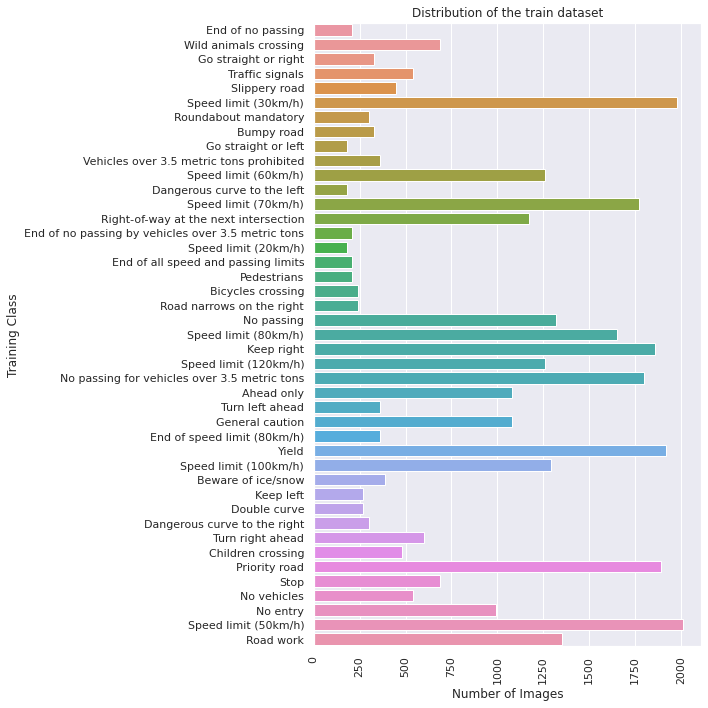

In [ ]:

# Distribution of images per class 
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.barplot(data=counts,x='training_samples_count',y='sign')
plt.xticks(rotation=90)
plt.ylabel('Training Class')
plt.xlabel('Number of Images');
plt.title("Distribution of the train dataset")
plt.tight_layout()
#plt.savefig('training_set_counts.png')



#generate random image max 5 raw & clos

In [ ]:
"""

def get_random_samples(n_max):
    selected = list()
    n_raw=5
    for current_label in range(n_raw):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1

    assert len(selected) ==  n_raw*n_max
    return list(selected)
    plt.figure(figsize=(12, 16))



count=0
cols = 10
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(5,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
plt.tight_layout()
#plt.savefig('random_examples.png')

"""

"\n\ndef get_random_samples(n_max):\n    selected = list()\n    n_raw=5\n    for current_label in range(n_raw):\n        found=0\n        while found<n_max:\n            ii = np.random.randint(len(y_train))\n            \n            if current_label == y_train[ii]:\n                selected.append(ii)\n                found+=1\n\n    assert len(selected) ==  n_raw*n_max\n    return list(selected)\n    plt.figure(figsize=(12, 16))\n\n\n\ncount=0\ncols = 10\nfor ii in get_random_samples(cols):\n    count+=1\n    plt.subplot(5,cols,count)\n    plt.imshow(X_train[ii])\n    plt.axis('off')\nplt.tight_layout()\n#plt.savefig('random_examples.png')\n\n"

#**Pre-process the Data Set (normalization, etc.)** 
Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data,

In [ ]:
import cv2
from sklearn.utils import shuffle
from skimage.transform import resize
from skimage.transform import rotate
from skimage.color import rgb2gray

In [ ]:
#generate random value of image
def someRandomImageId(nb = n_train):
    return int(np.random.rand()*nb)

#normalize the data
def normalize_features_pos(img_):
    return (img_-img_.mean())/(np.max(img_)-np.min(img_))

#resize the data to (32,32)
def resizeSize(img, x=32, y=32):
    return cv2.resize(img,(x, y), interpolation = cv2.INTER_CUBIC)

#crop roi in image
def crop(img, ROI):
    return img[(ROI[1]):(ROI[3]),(ROI[0]):(ROI[2])]

#add a new roi
def addROI(img, ROI, color=(255,0, 0)):
    copy = img.copy()
    return cv2.rectangle(copy,(ROI[0],ROI[1]),(ROI[2],ROI[3]),color)


# rectify Coords  for selecting ROI
def rectifyCoords(nb, sizes, coords):
    rectified = []
    for j in range(0, nb):
        x_ratio = image_shape_with_n_train[1] / sizes[j][0]
        y_ratio = image_shape_with_n_train[2] / sizes[j][1]
        rectified.append((int(coords[j][0]*x_ratio), int(coords[j][1]*y_ratio), \
                          int(coords[j][2]*x_ratio), int(coords[j][3]*y_ratio)))
    return rectified
    
#Augmenting function
def augment_img(img,ROI):
    #crop ROI 
    crop_ROI = crop(img, ROI)
    #Resize ROI (32,32)
    Resized_ROI=resizeSize(crop_ROI)
    #normalize ROI
    normalize_ROI=normalize_features_pos(Resized_ROI)
    #Rotate ROI by a small angle [-15°, 15°] 
    rotated_ROI = rotate(normalize_ROI,np.random.rand()*30-15)
    #GrayScal
    #GrayScal_ROI = rgb2gray(rotated_ROI)
    
    return rotated_ROI

#print Augmenting image
def plotAugmentation(*argv, figsize=(20, 5), save=None):
    fig = plt.figure(figsize=figsize)
    for i in range(0, len(argv[0])):    
        ax=fig.add_subplot(1,len(argv[0]),i+1)        
        ax.imshow(argv[0][i][1])
        ax.set_title(argv[0][i][0])
    if save != None:
        plt.savefig(save)
    plt.show() 


rectified_train_coords = rectifyCoords(n_train, train_sizes, train_coords)
rectified_valid_coords = rectifyCoords(n_validation, valid_sizes, valid_coords)
rectified_test_coords  = rectifyCoords(n_test,  test_sizes,  test_coords)

print("Augmenting functions defined.")


Augmenting functions defined.


# **Region of interst Cropping** &  **Normalize**
- Neural networks offer much better results when the data is normalized because it creates more variation in the data values. Practically speaking normalizing the data means that the input values range from -1 to 1 instead of being between 0 and 255 in the case of images.
- In order to add more training data and to make the network more accurate, I rotate randomly the images by a small angle [-15°, 15°] around the center of the Region Of Interest.

(32, 32, 3)


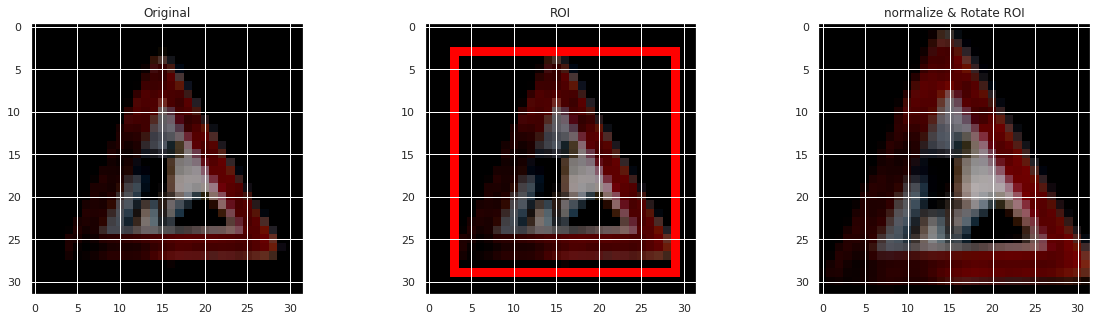

In [ ]:

i = someRandomImageId()
#print(i)
#i=34
arguments = (('Original', X_train[i]), ('ROI', addROI(X_train[i], rectified_train_coords[i])),('normalize & Rotate ROI', augment_img(X_train[i], rectified_train_coords[i])))
print(augment_img(X_train[i], rectified_train_coords[i]).shape)
plotAugmentation(arguments)



#**Pre-processing All The Dataset**

In [ ]:
#Training data splitting for validation dataset

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)


In [ ]:
X_train = normalize_features_pos(X_train)
X_valid = normalize_features_pos(X_valid)
X_test = normalize_features_pos(X_test)

In [ ]:

#Augmented All dataset Using the augmented function

X_train_transf =[]
y_train_transf = []

for ii in range(0,num_img_needed):
    img = X_train[ii]
    label = y_train[ii]
    imgout = augment_img(img, rectified_train_coords[ii])
    imgout.shape = (1,) + imgout.shape + (1,)
    X_train_transf.append(imgout)
    y_train_transf.append(label)
    for j in range(10):
        imgout = augment_img(img, rectified_train_coords[ii])
        imgout.shape = (1,) + imgout.shape + (1,)
        X_train_transf.append(imgout)
        y_train_transf.append(label)



X_train_transf = np.concatenate(X_train_transf,axis=0)
y_train_transf = np.array(y_train_transf)


X_test_transf = []
X_valid_transf = []

for ii in range(X_valid.shape[0]):
    img = X_valid[ii]
    img = augment_img(img, rectified_train_coords[ii])
    img.shape = (1,) + img.shape + (1,)
    X_valid_transf.append(img)
    
for ii in range(X_test.shape[0]):
    img = X_test[ii]
    img = augment_img(img, rectified_train_coords[ii])
    img.shape = (1,) + img.shape + (1,)
    X_test_transf.append(img)


X_test_transf = np.concatenate(X_test_transf,axis=0)
X_valid_transf = np.concatenate(X_valid_transf,axis=0)




'\n#Augmented All dataset Using the augmented function\n\nX_train_transf =[]\ny_train_transf = []\n\nfor ii in range(0,num_img_needed):\n    img = X_train[ii]\n    label = y_train[ii]\n    imgout = augment_img(img, rectified_train_coords[ii])\n    imgout.shape = (1,) + imgout.shape + (1,)\n    X_train_transf.append(imgout)\n    y_train_transf.append(label)\n    for j in range(10):\n        imgout = augment_img(img, rectified_train_coords[ii])\n        imgout.shape = (1,) + imgout.shape + (1,)\n        X_train_transf.append(imgout)\n        y_train_transf.append(label)\n\n\n\nX_train_transf = np.concatenate(X_train_transf,axis=0)\ny_train_transf = np.array(y_train_transf)\n\n\nX_test_transf = []\nX_valid_transf = []\n\nfor ii in range(X_valid.shape[0]):\n    img = X_valid[ii]\n    img = augment_img(img, rectified_train_coords[ii])\n    img.shape = (1,) + img.shape + (1,)\n    X_valid_transf.append(img)\n    \nfor ii in range(X_test.shape[0]):\n    img = X_test[ii]\n    img = augment_img

# **Model Architecture**

 **LeNet**
 

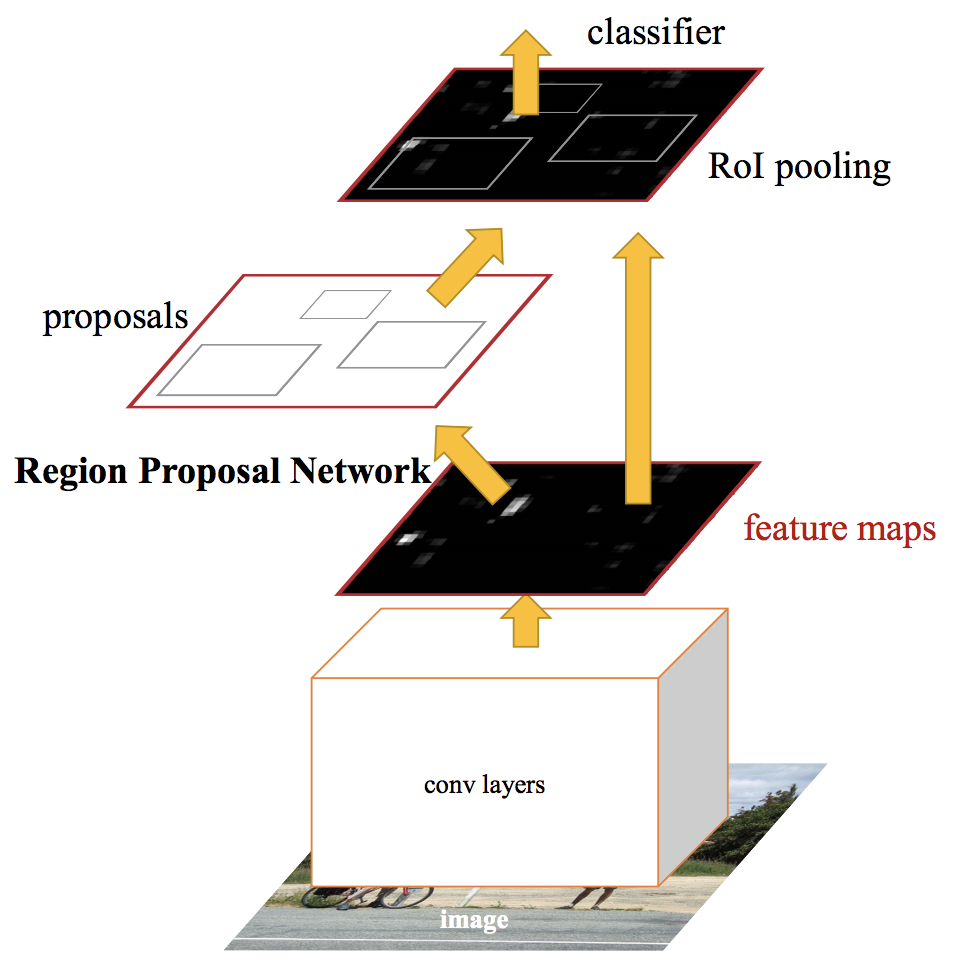


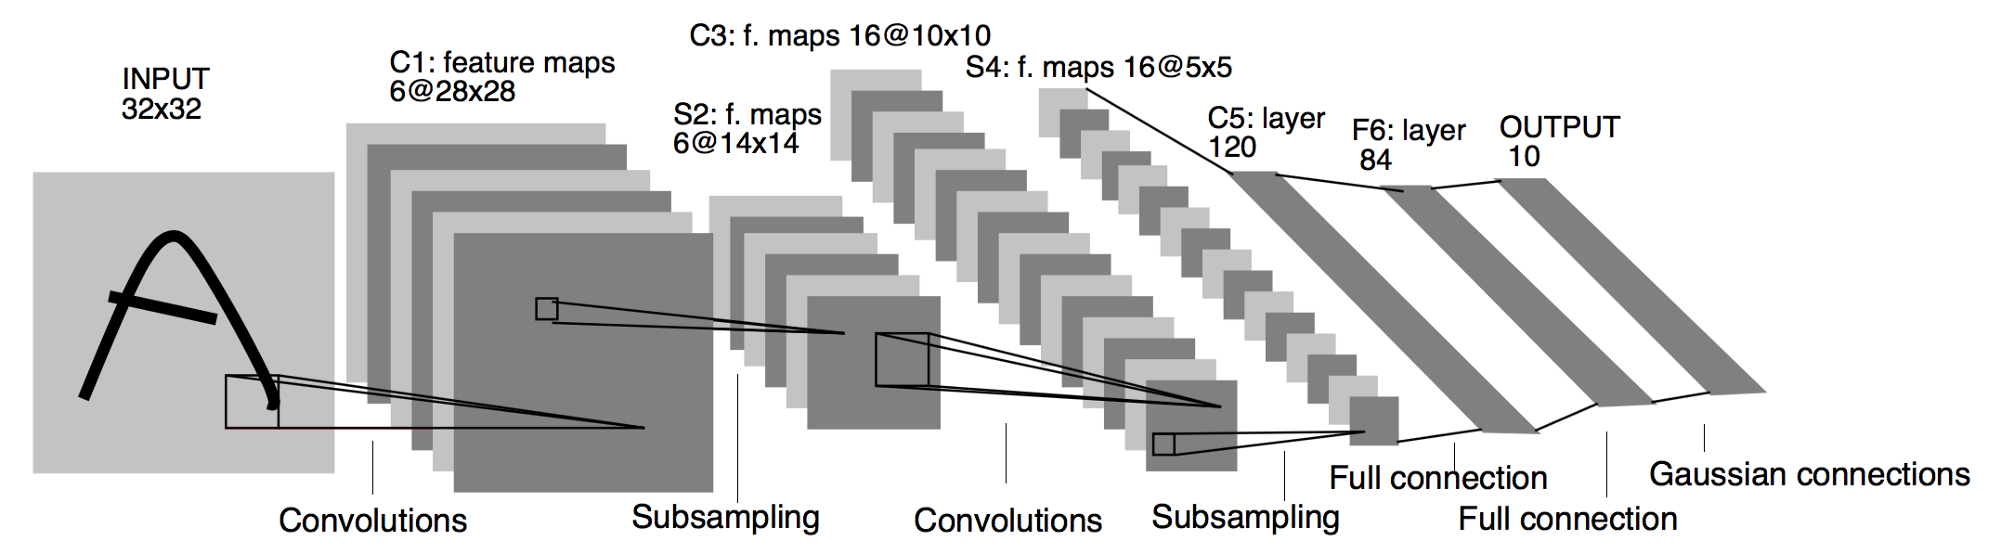

In [ ]:
!pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 5.4 MB/s 


In [ ]:
import tensorflow as tf
import tf_slim as slim
tf.compat.v1.disable_eager_execution()

In [ ]:
#Test GPU 
#tf.test.gpu_device_name()

In [ ]:
def LeNet(x): 
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation 1. using relu Activation Function
    conv1 = tf.nn.relu(conv1)

    # Max Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Flatten Input : reduces the input data into a single dimension 5x5x16 = 400
    # Flatten. Input = 5x5x16. Output = 400.
    flattened   = slim.flatten(conv2)
    
    #Matrix multiplication
    #input: 1x400
    #weight: 400x120 
    #Matrix multiplication(dot product rule)
    #output = 1x400 * 400*120 => 1x120
    
     # Layer 3: Fully Connected. Input = 400. Output = 120.
    fullyc1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fullyc1_b = tf.Variable(tf.zeros(120))
    fullyc1   = tf.matmul(flattened, fullyc1_W) + fullyc1_b
    
    # Full connected layer activation 1.
    fullyc1    = tf.nn.relu(fullyc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fullyc2_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(120, 84), mean = 0, stddev = 0.1))
    fullyc2_b  = tf.Variable(tf.zeros(84))
    fullyc2    = tf.matmul(fullyc1, fullyc2_W) + fullyc2_b
    
    # Full connected layer activation 2.
    fullyc2    = tf.nn.relu(fullyc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fullyc3_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(84, 43), mean = 0, stddev = 0.1))
    fullyc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fullyc2, fullyc3_W) + fullyc3_b
    
    return logits

print("Model defined.")

Model defined.


# **Features and Labels**
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels. .

In [ ]:
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.compat.v1.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# **Train & Validate the Model**
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
"""      
Hyper parameters

"""

#learning rates745
learning_rate = 0.001
#the number of times the algorithm sees the entire data set
epochs = 42
#the number of samples (inputs) that will be passed through to the network at one time.
batch_size = 128


In [ ]:
logits = LeNet(x)
#relation between probabilities and Erreur function CE
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

# **Model Evaluation**
Evaluate how well the accuracy of the model for a given dataset.

In [ ]:
correct_prediction = tf.equal(predict_operation, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.compat.v1.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples, total_accuracy/num_examples

print("Evaluate function defined.")

Evaluate function defined.


In [ ]:
from sklearn.utils import shuffle
from time import time
import logging, datetime

In [ ]:

"""
Log File for Metadata 
"""
logger = logging.getLogger()
#create file handler for logger
def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)

def log(message):
    #outputs to Colab console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)

setup_file_logger('training_Modul.log')

# **Train the Model**

In [ ]:
# tf.compat.v1.reset_default_graph()

In [ ]:
validation_accuracy = []
validation_loss = []
training_accuracy = []
training_loss = []
saver1 = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Start Training...")
    print("Number of epochs : {}".format(epochs))
    print("Batch size : {}".format(batch_size))
    print("Learning rate : {}".format(learning_rate))
    print()
    

    for i in range(epochs):
      try:
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                        
            log("EPOCH {} ...".format(i+1))
            # Training data
            train_loss, train_accuracy = evaluate(X_train, y_train)
            training_accuracy.append(train_accuracy)
            training_loss.append(train_loss)
            log("Training Accuracy = {:.3f}".format(train_accuracy))
            print("Training error = {:.3f} ".format( train_loss ))
            # Validation data
            valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
            validation_accuracy.append(valid_accuracy)
            validation_loss.append(valid_loss)
            log("Validation Accuracy = {:.3f}".format(valid_accuracy))
            print("Validation error = {:.3f}".format(valid_loss))
            print()


      except KeyboardInterrupt:
          test_loss, test_accuracy = evaluate(X_valid, y_valid)
          log('Accuracy Model On Test Images: {}'.format(test_accuracy))
          print('Loss Model On Test Images: {}'.format(test_loss))   
          break

        
    saver1.save(sess, 'LeNet_Modul')
    print("Model saved")

Start Training...
Number of epochs : 42
Batch size : 128
Learning rate : 0.001



INFO:root:EPOCH 1 ...


2022-08-15 11:23:12.747708 EPOCH 1 ...


INFO:root:Training Accuracy = 0.844


2022-08-15 11:23:35.218242 Training Accuracy = 0.844
Training error = 0.566 


INFO:root:Validation Accuracy = 0.771


2022-08-15 11:23:38.658213 Validation Accuracy = 0.771
Validation error = 0.843



INFO:root:EPOCH 2 ...


2022-08-15 11:24:11.897185 EPOCH 2 ...


INFO:root:Training Accuracy = 0.919


2022-08-15 11:24:24.305192 Training Accuracy = 0.919
Training error = 0.291 


INFO:root:Validation Accuracy = 0.824


2022-08-15 11:24:25.738540 Validation Accuracy = 0.824
Validation error = 0.658



INFO:root:EPOCH 3 ...


2022-08-15 11:24:51.431077 EPOCH 3 ...


INFO:root:Training Accuracy = 0.962


2022-08-15 11:25:02.767017 Training Accuracy = 0.962
Training error = 0.158 


INFO:root:Validation Accuracy = 0.878


2022-08-15 11:25:04.247929 Validation Accuracy = 0.878
Validation error = 0.493



INFO:root:EPOCH 4 ...


2022-08-15 11:25:29.292521 EPOCH 4 ...


INFO:root:Training Accuracy = 0.975


2022-08-15 11:25:40.702624 Training Accuracy = 0.975
Training error = 0.108 


INFO:root:Validation Accuracy = 0.884


2022-08-15 11:25:42.179247 Validation Accuracy = 0.884
Validation error = 0.503



INFO:root:EPOCH 5 ...


2022-08-15 11:26:09.387056 EPOCH 5 ...


INFO:root:Training Accuracy = 0.982


2022-08-15 11:26:20.538582 Training Accuracy = 0.982
Training error = 0.079 


INFO:root:Validation Accuracy = 0.897


2022-08-15 11:26:21.942979 Validation Accuracy = 0.897
Validation error = 0.427



INFO:root:EPOCH 6 ...


2022-08-15 11:26:47.469670 EPOCH 6 ...


INFO:root:Training Accuracy = 0.982


2022-08-15 11:26:58.516069 Training Accuracy = 0.982
Training error = 0.067 


INFO:root:Validation Accuracy = 0.879


2022-08-15 11:26:59.896729 Validation Accuracy = 0.879
Validation error = 0.513



INFO:root:EPOCH 7 ...


2022-08-15 11:27:25.917668 EPOCH 7 ...


INFO:root:Training Accuracy = 0.987


2022-08-15 11:27:36.926996 Training Accuracy = 0.987
Training error = 0.052 


INFO:root:Validation Accuracy = 0.896


2022-08-15 11:27:38.398700 Validation Accuracy = 0.896
Validation error = 0.426



INFO:root:EPOCH 8 ...


2022-08-15 11:28:04.036108 EPOCH 8 ...


INFO:root:Training Accuracy = 0.992


2022-08-15 11:28:15.538894 Training Accuracy = 0.992
Training error = 0.036 


INFO:root:Validation Accuracy = 0.912


2022-08-15 11:28:17.015637 Validation Accuracy = 0.912
Validation error = 0.418



INFO:root:EPOCH 9 ...


2022-08-15 11:28:42.771704 EPOCH 9 ...


INFO:root:Training Accuracy = 0.991


2022-08-15 11:28:54.334053 Training Accuracy = 0.991
Training error = 0.038 


INFO:root:Validation Accuracy = 0.890


2022-08-15 11:28:55.786869 Validation Accuracy = 0.890
Validation error = 0.492



INFO:root:EPOCH 10 ...


2022-08-15 11:29:20.819383 EPOCH 10 ...


INFO:root:Training Accuracy = 0.995


2022-08-15 11:29:32.177145 Training Accuracy = 0.995
Training error = 0.025 


INFO:root:Validation Accuracy = 0.903


2022-08-15 11:29:33.621513 Validation Accuracy = 0.903
Validation error = 0.424



INFO:root:EPOCH 11 ...


2022-08-15 11:29:58.624950 EPOCH 11 ...


INFO:root:Training Accuracy = 0.988


2022-08-15 11:30:10.882787 Training Accuracy = 0.988
Training error = 0.039 


INFO:root:Validation Accuracy = 0.906


2022-08-15 11:30:12.312104 Validation Accuracy = 0.906
Validation error = 0.432



INFO:root:EPOCH 12 ...


2022-08-15 11:30:37.851631 EPOCH 12 ...


INFO:root:Training Accuracy = 0.996


2022-08-15 11:30:50.255134 Training Accuracy = 0.996
Training error = 0.020 


INFO:root:Validation Accuracy = 0.915


2022-08-15 11:30:51.713521 Validation Accuracy = 0.915
Validation error = 0.364



INFO:root:EPOCH 13 ...


2022-08-15 11:31:17.785358 EPOCH 13 ...


INFO:root:Training Accuracy = 0.996


2022-08-15 11:31:29.248370 Training Accuracy = 0.996
Training error = 0.018 


INFO:root:Validation Accuracy = 0.907


2022-08-15 11:31:30.719217 Validation Accuracy = 0.907
Validation error = 0.498



INFO:root:EPOCH 14 ...


2022-08-15 11:31:55.743731 EPOCH 14 ...


INFO:root:Training Accuracy = 0.993


2022-08-15 11:32:07.187445 Training Accuracy = 0.993
Training error = 0.027 


INFO:root:Validation Accuracy = 0.895


2022-08-15 11:32:08.606318 Validation Accuracy = 0.895
Validation error = 0.530



INFO:root:EPOCH 15 ...


2022-08-15 11:32:34.908020 EPOCH 15 ...


INFO:root:Training Accuracy = 0.995


2022-08-15 11:32:46.390382 Training Accuracy = 0.995
Training error = 0.018 


INFO:root:Validation Accuracy = 0.914


2022-08-15 11:32:47.876857 Validation Accuracy = 0.914
Validation error = 0.478



INFO:root:EPOCH 16 ...


2022-08-15 11:33:13.061253 EPOCH 16 ...


INFO:root:Training Accuracy = 0.994


2022-08-15 11:33:24.560838 Training Accuracy = 0.994
Training error = 0.021 


INFO:root:Validation Accuracy = 0.907


2022-08-15 11:33:26.045429 Validation Accuracy = 0.907
Validation error = 0.489



INFO:root:EPOCH 17 ...


2022-08-15 11:33:51.239914 EPOCH 17 ...


INFO:root:Training Accuracy = 0.996


2022-08-15 11:34:02.668701 Training Accuracy = 0.996
Training error = 0.013 


INFO:root:Validation Accuracy = 0.919


2022-08-15 11:34:04.149914 Validation Accuracy = 0.919
Validation error = 0.464



INFO:root:EPOCH 18 ...


2022-08-15 11:34:30.340798 EPOCH 18 ...


INFO:root:Training Accuracy = 0.997


2022-08-15 11:34:41.596502 Training Accuracy = 0.997
Training error = 0.010 


INFO:root:Validation Accuracy = 0.915


2022-08-15 11:34:43.081574 Validation Accuracy = 0.915
Validation error = 0.434



INFO:root:EPOCH 19 ...


2022-08-15 11:35:08.239802 EPOCH 19 ...


INFO:root:Training Accuracy = 0.993


2022-08-15 11:35:19.431086 Training Accuracy = 0.993
Training error = 0.023 


INFO:root:Validation Accuracy = 0.900


2022-08-15 11:35:20.884366 Validation Accuracy = 0.900
Validation error = 0.573



INFO:root:EPOCH 20 ...


2022-08-15 11:35:45.879863 EPOCH 20 ...


INFO:root:Training Accuracy = 0.995


2022-08-15 11:35:57.333434 Training Accuracy = 0.995
Training error = 0.016 


INFO:root:Validation Accuracy = 0.916


2022-08-15 11:35:58.852193 Validation Accuracy = 0.916
Validation error = 0.495



INFO:root:EPOCH 21 ...


2022-08-15 11:36:25.494641 EPOCH 21 ...


INFO:root:Training Accuracy = 0.996


2022-08-15 11:36:36.727579 Training Accuracy = 0.996
Training error = 0.015 


INFO:root:Validation Accuracy = 0.918


2022-08-15 11:36:38.179297 Validation Accuracy = 0.918
Validation error = 0.455



INFO:root:EPOCH 22 ...


2022-08-15 11:37:03.362771 EPOCH 22 ...


INFO:root:Training Accuracy = 0.996


2022-08-15 11:37:14.849190 Training Accuracy = 0.996
Training error = 0.012 


INFO:root:Validation Accuracy = 0.915


2022-08-15 11:37:16.342906 Validation Accuracy = 0.915
Validation error = 0.468



INFO:root:EPOCH 23 ...


2022-08-15 11:37:41.569033 EPOCH 23 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:37:52.933139 Training Accuracy = 1.000
Training error = 0.002 


INFO:root:Validation Accuracy = 0.942


2022-08-15 11:37:54.381254 Validation Accuracy = 0.942
Validation error = 0.326



INFO:root:EPOCH 24 ...


2022-08-15 11:38:19.409782 EPOCH 24 ...


INFO:root:Training Accuracy = 0.994


2022-08-15 11:38:31.673584 Training Accuracy = 0.994
Training error = 0.020 


INFO:root:Validation Accuracy = 0.914


2022-08-15 11:38:33.119187 Validation Accuracy = 0.914
Validation error = 0.528



INFO:root:EPOCH 25 ...


2022-08-15 11:38:58.360115 EPOCH 25 ...


INFO:root:Training Accuracy = 0.997


2022-08-15 11:39:09.426622 Training Accuracy = 0.997
Training error = 0.010 


INFO:root:Validation Accuracy = 0.919


2022-08-15 11:39:10.852356 Validation Accuracy = 0.919
Validation error = 0.495



INFO:root:EPOCH 26 ...


2022-08-15 11:39:36.111347 EPOCH 26 ...


INFO:root:Training Accuracy = 0.999


2022-08-15 11:39:47.369236 Training Accuracy = 0.999
Training error = 0.006 


INFO:root:Validation Accuracy = 0.936


2022-08-15 11:39:48.792839 Validation Accuracy = 0.936
Validation error = 0.416



INFO:root:EPOCH 27 ...


2022-08-15 11:40:13.939188 EPOCH 27 ...


INFO:root:Training Accuracy = 0.998


2022-08-15 11:40:25.182298 Training Accuracy = 0.998
Training error = 0.012 


INFO:root:Validation Accuracy = 0.923


2022-08-15 11:40:26.584249 Validation Accuracy = 0.923
Validation error = 0.580



INFO:root:EPOCH 28 ...


2022-08-15 11:40:52.822671 EPOCH 28 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:41:03.594189 Training Accuracy = 1.000
Training error = 0.001 


INFO:root:Validation Accuracy = 0.941


2022-08-15 11:41:05.010731 Validation Accuracy = 0.941
Validation error = 0.400



INFO:root:EPOCH 29 ...


2022-08-15 11:41:30.165208 EPOCH 29 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:41:41.596248 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.943


2022-08-15 11:41:43.059216 Validation Accuracy = 0.943
Validation error = 0.405



INFO:root:EPOCH 30 ...


2022-08-15 11:42:08.109216 EPOCH 30 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:42:19.034172 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.942


2022-08-15 11:42:20.444681 Validation Accuracy = 0.942
Validation error = 0.407



INFO:root:EPOCH 31 ...


2022-08-15 11:42:46.697270 EPOCH 31 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:42:57.810519 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.941


2022-08-15 11:42:59.278127 Validation Accuracy = 0.941
Validation error = 0.423



INFO:root:EPOCH 32 ...


2022-08-15 11:43:24.340379 EPOCH 32 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:43:35.502640 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.943


2022-08-15 11:43:36.888600 Validation Accuracy = 0.943
Validation error = 0.436



INFO:root:EPOCH 33 ...


2022-08-15 11:44:01.960019 EPOCH 33 ...


INFO:root:Training Accuracy = 0.990


2022-08-15 11:44:13.439148 Training Accuracy = 0.990
Training error = 0.046 


INFO:root:Validation Accuracy = 0.933


2022-08-15 11:44:14.916926 Validation Accuracy = 0.933
Validation error = 0.442



INFO:root:EPOCH 34 ...


2022-08-15 11:44:40.548198 EPOCH 34 ...


INFO:root:Training Accuracy = 0.998


2022-08-15 11:44:52.837177 Training Accuracy = 0.998
Training error = 0.006 


INFO:root:Validation Accuracy = 0.932


2022-08-15 11:44:54.295263 Validation Accuracy = 0.932
Validation error = 0.466



INFO:root:EPOCH 35 ...


2022-08-15 11:45:19.409074 EPOCH 35 ...


INFO:root:Training Accuracy = 0.999


2022-08-15 11:45:30.878012 Training Accuracy = 0.999
Training error = 0.005 


INFO:root:Validation Accuracy = 0.933


2022-08-15 11:45:32.354347 Validation Accuracy = 0.933
Validation error = 0.434



INFO:root:EPOCH 36 ...


2022-08-15 11:45:57.321019 EPOCH 36 ...


INFO:root:Training Accuracy = 0.997


2022-08-15 11:46:08.607970 Training Accuracy = 0.997
Training error = 0.010 


INFO:root:Validation Accuracy = 0.919


2022-08-15 11:46:10.048863 Validation Accuracy = 0.919
Validation error = 0.562



INFO:root:EPOCH 37 ...


2022-08-15 11:46:35.202126 EPOCH 37 ...


INFO:root:Training Accuracy = 0.998


2022-08-15 11:46:47.840938 Training Accuracy = 0.998
Training error = 0.006 


INFO:root:Validation Accuracy = 0.909


2022-08-15 11:46:49.281190 Validation Accuracy = 0.909
Validation error = 0.559



INFO:root:EPOCH 38 ...


2022-08-15 11:47:14.358520 EPOCH 38 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:47:26.076308 Training Accuracy = 1.000
Training error = 0.001 


INFO:root:Validation Accuracy = 0.939


2022-08-15 11:47:27.535990 Validation Accuracy = 0.939
Validation error = 0.427



INFO:root:EPOCH 39 ...


2022-08-15 11:47:52.663107 EPOCH 39 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:48:04.060958 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.938


2022-08-15 11:48:05.539296 Validation Accuracy = 0.938
Validation error = 0.459



INFO:root:EPOCH 40 ...


2022-08-15 11:48:33.703997 EPOCH 40 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:48:45.269163 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.940


2022-08-15 11:48:46.747607 Validation Accuracy = 0.940
Validation error = 0.462



INFO:root:EPOCH 41 ...


2022-08-15 11:49:13.444186 EPOCH 41 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:49:24.889269 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.937


2022-08-15 11:49:26.335097 Validation Accuracy = 0.937
Validation error = 0.483



INFO:root:EPOCH 42 ...


2022-08-15 11:49:51.716441 EPOCH 42 ...


INFO:root:Training Accuracy = 1.000


2022-08-15 11:50:03.119914 Training Accuracy = 1.000
Training error = 0.000 


INFO:root:Validation Accuracy = 0.936


2022-08-15 11:50:04.549995 Validation Accuracy = 0.936
Validation error = 0.498

Model saved


# **Accuracy and Loss visualization**
I want to visualize the decrease in loss and the increase in accuracy for the training and validation set.

Text(0.5, 0, 'Epoch')

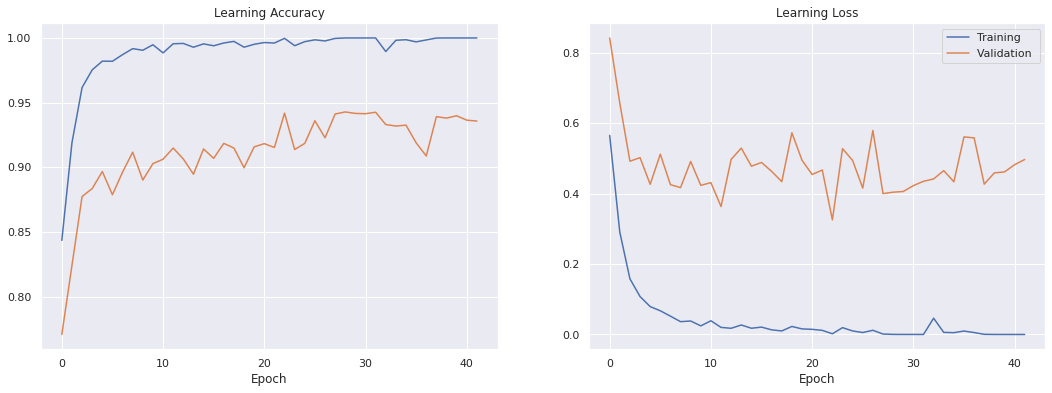

In [ ]:
def plot_curve(ax, data, label):
    x = len(data)
    y = np.arange(x)
    ax.plot(y, data, label=label)
    
fig = plt.figure(figsize=(18, 6))
ax=fig.add_subplot(1,2,1)
plot_curve(ax, training_accuracy, "Training")
plot_curve(ax, validation_accuracy, "Validation")
ax.set_title('Learning Accuracy')
plt.xlabel('Epoch')
ax=fig.add_subplot(1,2,2) 
plot_curve(ax, training_loss, "Training ")
plot_curve(ax, validation_loss, "Validation ")
ax.set_title('Learning Loss')
plt.legend()
plt.xlabel('Epoch')
#plt.savefig("learning_curve.png")

# **Test the model**
Once I was happy with my validation accuracy, I performed the final test on the test data.

In [ ]:
with tf.compat.v1.Session() as sess:
    saver1.restore(sess, tf.train.latest_checkpoint('.'))

    train_loss, train_accuracy = evaluate(X_train, y_train)
    print("Accuracy Model On Train Images: {:.3f}".format(train_accuracy))
    
    valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
    print("Accuracy Model On Valid Images: {:.3f}".format(valid_accuracy))    
    
    test_loss, test_accuracy = evaluate(X_valid, y_valid)
    print('Accuracy Model On Test Images: {:.3f}'.format(test_accuracy))
     

INFO:tensorflow:Restoring parameters from ./LeNet_Modul


Accuracy Model On Train Images: 1.000
Accuracy Model On Valid Images: 0.936
Accuracy Model On Test Images: 0.936


# **Test a Model on New Images**

In [ ]:
!unzip test-traffic-signs.zip

Archive:  test-traffic-signs.zip
 extracting: test-traffic-signs1/.gitkeep  
  inflating: test-traffic-signs1/1x.png  
  inflating: test-traffic-signs1/2x.png  
  inflating: test-traffic-signs1/3x.png  
  inflating: test-traffic-signs1/5x.png  
  inflating: test-traffic-signs1/6x.png  
  inflating: test-traffic-signs1/8x.png  
  inflating: test-traffic-signs1/9x.png  
  inflating: test-traffic-signs1/Teststop.png  


(8, 32, 32, 3)


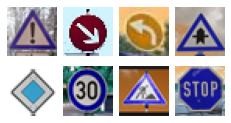

In [ ]:
#reading in an image
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,4, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
my_images = []
# my_New_images_Nor=[]
for i, img in enumerate(glob.glob('./test-traffic-signs1/*.png')):
    image = cv2.imread(img)
    colored_img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    my_images.append(colored_img)
    #my_New_image_Nor=augment_img(my_images,rectified_train_coords[i])
    #my_New_images_Nor.append(my_New_image_Nor)
    axs[i].axis('off')
    axs[i].imshow(image)


my_New_images= np.asarray(my_images)

  
# resize(my_New_images,(32,32))
my_New_images_Nor = normalize_features_pos(my_New_images)
print(my_New_images_Nor.shape)


After Normalising


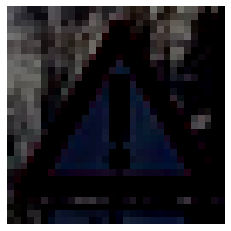

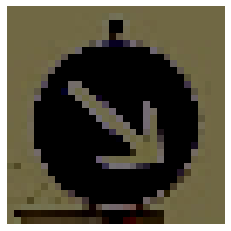

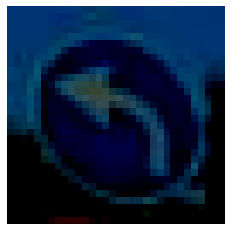

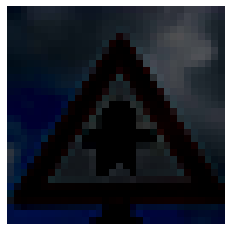

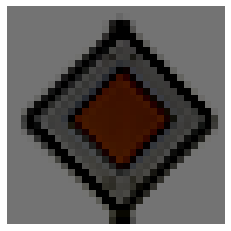

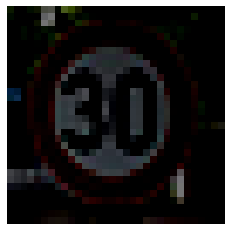

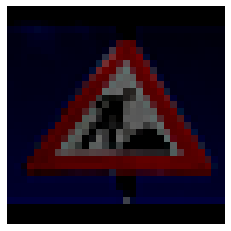

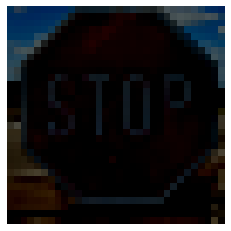

<Figure size 432x288 with 0 Axes>

In [ ]:
print("After Normalising")
for i, image in enumerate(my_New_images_Nor):
    plt.imshow(image)
    plt.axis('off')
    plt.figure()

For each of the new images, print out the model's softmax probabilities to show the certainty of the model's predictions (limit the output to the top 3 probabilities for each image). **tf.nn.top_k** could prove helpful here.

The example below demonstrates how  **tf.nn.top_k** can be used to find the top k predictions for each image.

**tf.nn.top_k** will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. tk.nn.top_k is used to choose the three classes with the highest probability:

(5, 6) array

a = np.array(
  
  [[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]]
         )

Running it through sess.run(tf.nn.top_k(tf.constant(a), k=3)) produces:

TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))

Looking just at the first row we get [ 0.34763842,  0.24879643,  0.12789202], you can confirm these are the 3 largest probabilities in a. You'll also notice [3, 0, 5] are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./LeNet_Modul


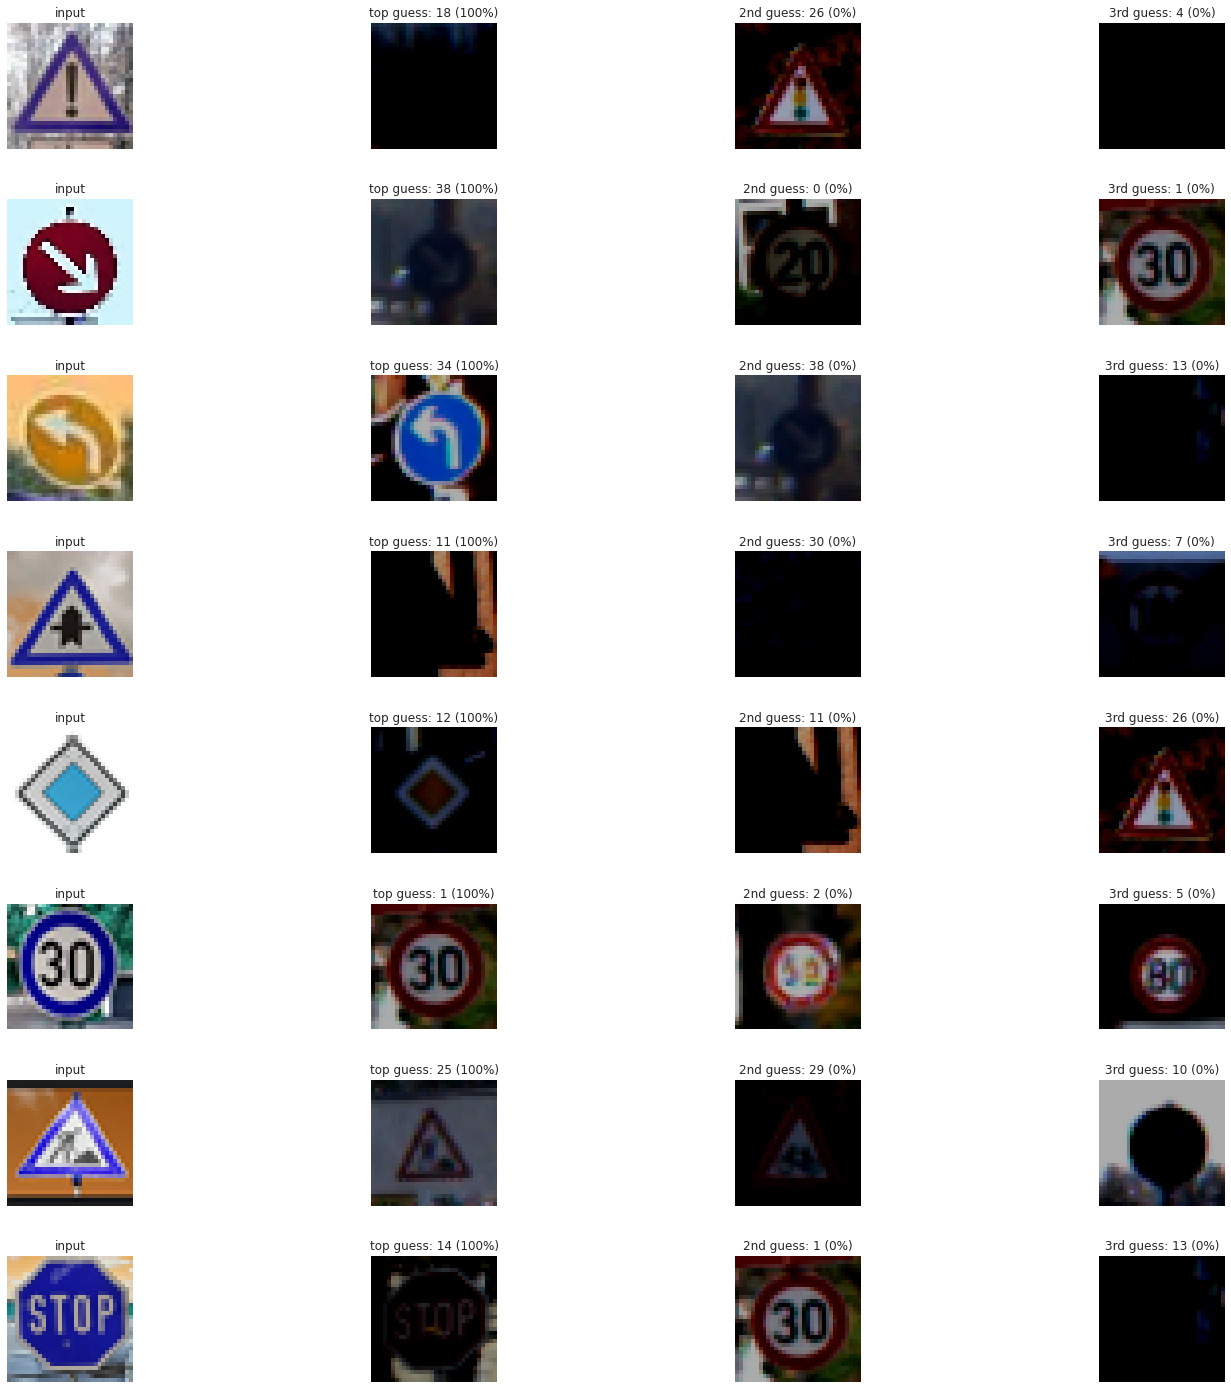

In [ ]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver1 = tf.compat.v1.train.import_meta_graph('./LeNet_Modul.meta')
    saver1.restore(sess, "./LeNet_Modul")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x:my_New_images_Nor})
    my_top_k = sess.run(top_k, feed_dict={x:my_New_images_Nor})
    #print(my_top_k)

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(25, 25))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))